# Chapter 7: Cellular Automata（セル・オートマトン）

このノートブックは [Nature of Code](https://natureofcode.com/cellular-automata/) の第7章をJuliaで実装したものです。

## 概要

セル・オートマトン（CA）は、離散的なセルのグリッド上で動作するシステムです。
各セルは有限の状態を持ち、単純なルールに基づいて次の世代の状態が決まります。

### 基本要素

1. **グリッド**: セルが配置される空間（1D、2D、3D...）
2. **状態**: 各セルが取りうる値（多くの場合0か1）
3. **近傍**: ルール適用時に参照するセルの範囲
4. **ルール**: 現在の状態と近傍から次の状態を決める規則

In [1]:
using Plots

## 7.1 Elementary Cellular Automata（1次元CA）

Stephen Wolframが研究した最も単純なCA。
1次元の配列で、各セルの次の状態は左隣・自分・右隣の3セルで決まります。

### Wolframルール

3セルの組み合わせは 2³ = 8通り。各組み合わせに対して出力が0か1なので、
可能なルールセットは 2⁸ = 256通りあります。

ルール番号は、8つの出力を2進数として解釈した値です。

In [2]:
# ルール番号からルールセットを生成
function createRuleset(ruleNumber::Int)
    ruleset = zeros(Int, 8)
    for i in 0:7
        ruleset[i+1] = (ruleNumber >> i) & 1
    end
    return ruleset
end

# ルール90を表示
rule90 = createRuleset(90)
println("Rule 90:")
println("111 110 101 100 011 010 001 000")
println(" $(rule90[8])   $(rule90[7])   $(rule90[6])   $(rule90[5])   $(rule90[4])   $(rule90[3])   $(rule90[2])   $(rule90[1])")

Rule 90:


111 110 101 100 011 010 001 000
 0   1   0   1   1   0   1   0


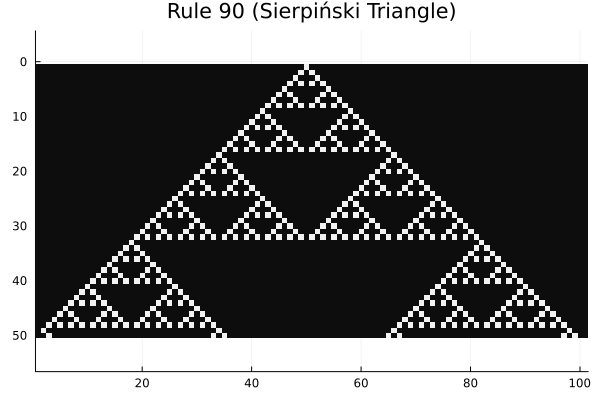

In [3]:
# 1D CAシミュレーション
function simulate_1d_ca(ruleNumber::Int, width::Int, generations::Int)
    ruleset = createRuleset(ruleNumber)
    
    # 結果を格納する行列
    result = zeros(Int, generations, width)
    
    # 初期状態：中央に1つだけ1を置く
    cells = zeros(Int, width)
    cells[width ÷ 2] = 1
    result[1, :] = cells
    
    for gen in 2:generations
        nextCells = zeros(Int, width)
        
        for i in 2:width-1
            left = cells[i-1]
            center = cells[i]
            right = cells[i+1]
            
            # 3セルの状態を2進数としてインデックスを計算
            index = left * 4 + center * 2 + right + 1
            nextCells[i] = ruleset[index]
        end
        
        cells = nextCells
        result[gen, :] = cells
    end
    
    return result
end

# Rule 90（シェルピンスキーの三角形）
result90 = simulate_1d_ca(90, 101, 50)
heatmap(result90, c=:grays, yflip=true, colorbar=false, 
        title="Rule 90 (Sierpiński Triangle)", aspect_ratio=:equal)

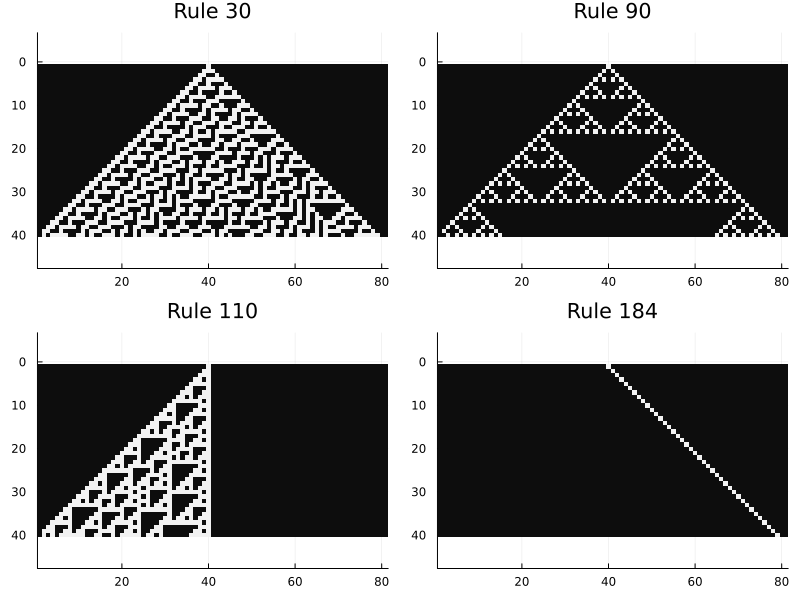

In [4]:
# 複数のルールを比較
function compare_rules(rules::Vector{Int})
    plots = []
    for rule in rules
        result = simulate_1d_ca(rule, 81, 40)
        p = heatmap(result, c=:grays, yflip=true, colorbar=false,
                   title="Rule $rule", aspect_ratio=:equal)
        push!(plots, p)
    end
    plot(plots..., layout=(2, 2), size=(800, 600))
end

compare_rules([30, 90, 110, 184])

## 7.2 Wolframの分類

Wolframは256のルールを4つのクラスに分類しました：

| クラス | 挙動 | 例 |
|--------|------|----|
| Class 1 | 均一 | すべてのセルが同じ状態に収束 |
| Class 2 | 反復 | 周期的なパターンが出現 |
| Class 3 | ランダム | カオス的で予測不可能 |
| Class 4 | 複雑 | 秩序とカオスの境界（最も興味深い） |

**Rule 110**はClass 4に属し、チューリング完全であることが証明されています！

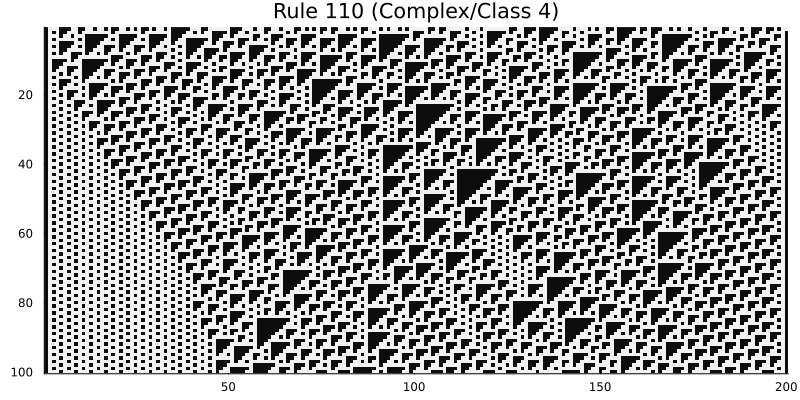

In [5]:
# ランダムな初期状態でRule 110
function simulate_1d_ca_random(ruleNumber::Int, width::Int, generations::Int)
    ruleset = createRuleset(ruleNumber)
    result = zeros(Int, generations, width)
    
    # ランダムな初期状態
    cells = rand([0, 1], width)
    result[1, :] = cells
    
    for gen in 2:generations
        nextCells = zeros(Int, width)
        
        for i in 2:width-1
            left = cells[i-1]
            center = cells[i]
            right = cells[i+1]
            index = left * 4 + center * 2 + right + 1
            nextCells[i] = ruleset[index]
        end
        
        cells = nextCells
        result[gen, :] = cells
    end
    
    return result
end

result110 = simulate_1d_ca_random(110, 200, 100)
heatmap(result110, c=:grays, yflip=true, colorbar=false,
        title="Rule 110 (Complex/Class 4)", size=(800, 400))

## 7.3 Game of Life（ライフゲーム）

John Horton Conwayが1970年に考案した2次元CA。
シンプルなルールから驚くほど複雑なパターンが生まれます。

### ルール

各セルは8つの近傍を持ち、以下のルールで次世代が決まります：

1. **死亡（過疎）**: 生きているセルの近傍に生きているセルが2未満 → 死
2. **死亡（過密）**: 生きているセルの近傍に生きているセルが3より多い → 死
3. **誕生**: 死んでいるセルの近傍にちょうど3つの生きているセル → 生
4. **維持**: それ以外 → 現状維持

In [6]:
function count_neighbors(grid::Matrix{Int}, x::Int, y::Int)
    rows, cols = size(grid)
    count = 0
    
    for i in -1:1
        for j in -1:1
            if i == 0 && j == 0
                continue
            end
            
            # 境界をトーラス状に接続
            ni = mod1(x + i, rows)
            nj = mod1(y + j, cols)
            count += grid[ni, nj]
        end
    end
    
    return count
end

function game_of_life_step(grid::Matrix{Int})
    rows, cols = size(grid)
    nextGrid = zeros(Int, rows, cols)
    
    for i in 1:rows
        for j in 1:cols
            neighbors = count_neighbors(grid, i, j)
            state = grid[i, j]
            
            if state == 1
                # 生きているセル
                if neighbors < 2 || neighbors > 3
                    nextGrid[i, j] = 0  # 死亡
                else
                    nextGrid[i, j] = 1  # 維持
                end
            else
                # 死んでいるセル
                if neighbors == 3
                    nextGrid[i, j] = 1  # 誕生
                end
            end
        end
    end
    
    return nextGrid
end

game_of_life_step (generic function with 1 method)

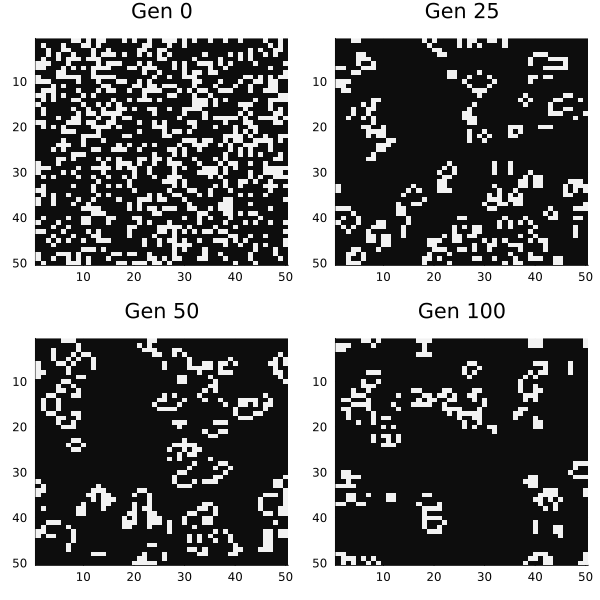

In [7]:
# ランダムな初期状態でシミュレーション
function simulate_game_of_life(width::Int, height::Int, generations::Int; density=0.3)
    grid = rand(height, width) .< density
    grid = Int.(grid)
    
    history = [copy(grid)]
    
    for _ in 1:generations
        grid = game_of_life_step(grid)
        push!(history, copy(grid))
    end
    
    return history
end

history = simulate_game_of_life(50, 50, 100)

# 数フレームを表示
p1 = heatmap(history[1], c=:grays, yflip=true, colorbar=false, title="Gen 0")
p2 = heatmap(history[26], c=:grays, yflip=true, colorbar=false, title="Gen 25")
p3 = heatmap(history[51], c=:grays, yflip=true, colorbar=false, title="Gen 50")
p4 = heatmap(history[101], c=:grays, yflip=true, colorbar=false, title="Gen 100")

plot(p1, p2, p3, p4, layout=(2,2), size=(600, 600))

## 7.4 有名なパターン

### Still Lifes（静止物体）
変化しないパターン

### Oscillators（振動子）
周期的に元の状態に戻るパターン

### Spaceships（宇宙船）
移動するパターン（グライダーなど）

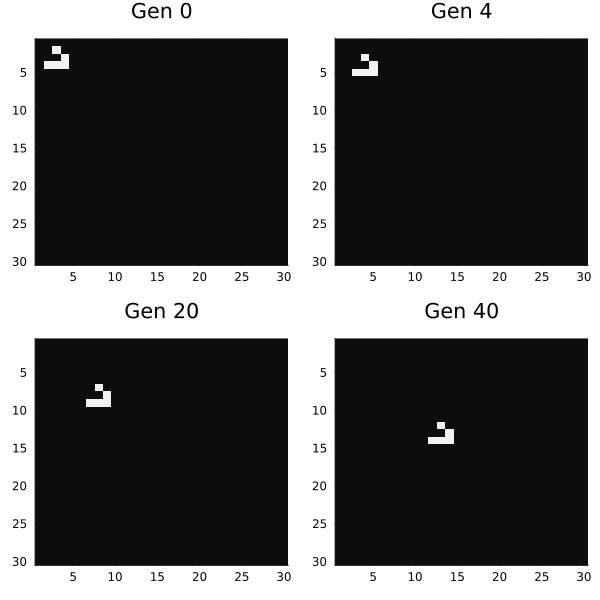

In [8]:
# グライダー（Glider）
function create_glider(grid::Matrix{Int}, x::Int, y::Int)
    # グライダーパターン
    pattern = [
        [0, 1, 0],
        [0, 0, 1],
        [1, 1, 1]
    ]
    
    for i in 1:3
        for j in 1:3
            grid[x+i-1, y+j-1] = pattern[i][j]
        end
    end
    return grid
end

# グライダーのシミュレーション
function simulate_glider()
    grid = zeros(Int, 30, 30)
    grid = create_glider(grid, 2, 2)
    
    history = [copy(grid)]
    for _ in 1:60
        grid = game_of_life_step(grid)
        push!(history, copy(grid))
    end
    
    # 4世代ごとに表示（グライダーの周期）
    p1 = heatmap(history[1], c=:grays, yflip=true, colorbar=false, title="Gen 0")
    p2 = heatmap(history[5], c=:grays, yflip=true, colorbar=false, title="Gen 4")
    p3 = heatmap(history[21], c=:grays, yflip=true, colorbar=false, title="Gen 20")
    p4 = heatmap(history[41], c=:grays, yflip=true, colorbar=false, title="Gen 40")
    
    plot(p1, p2, p3, p4, layout=(2,2), size=(600, 600))
end

simulate_glider()

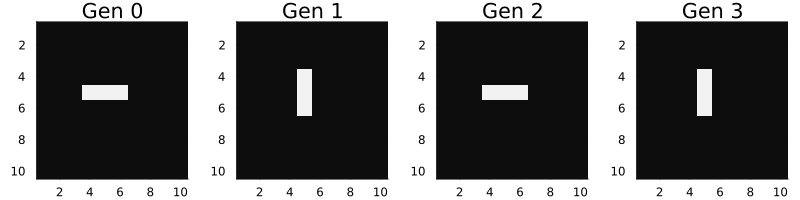

In [9]:
# ブリンカー（Blinker）- 周期2の振動子
function simulate_blinker()
    grid = zeros(Int, 10, 10)
    grid[5, 4:6] .= 1  # 横一列
    
    history = [copy(grid)]
    for _ in 1:4
        grid = game_of_life_step(grid)
        push!(history, copy(grid))
    end
    
    p1 = heatmap(history[1], c=:grays, yflip=true, colorbar=false, title="Gen 0")
    p2 = heatmap(history[2], c=:grays, yflip=true, colorbar=false, title="Gen 1")
    p3 = heatmap(history[3], c=:grays, yflip=true, colorbar=false, title="Gen 2")
    p4 = heatmap(history[4], c=:grays, yflip=true, colorbar=false, title="Gen 3")
    
    plot(p1, p2, p3, p4, layout=(1,4), size=(800, 200))
end

simulate_blinker()

## 7.5 グライダー銃（Gosper Glider Gun）

Bill Gosperが発見した、グライダーを連続的に生成するパターン。

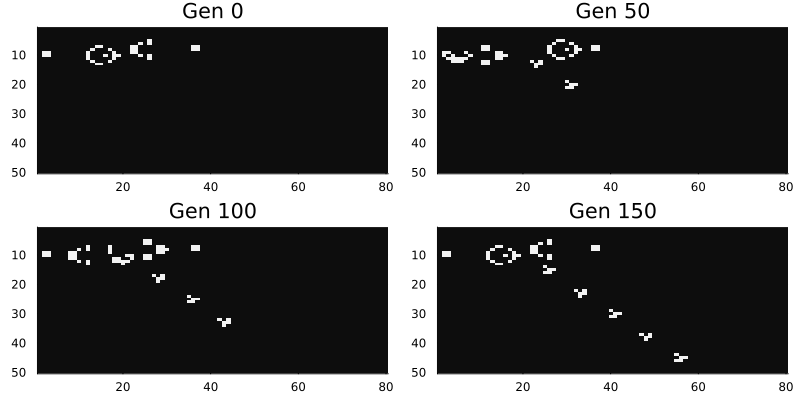

In [10]:
function create_gosper_glider_gun(grid::Matrix{Int}, x::Int, y::Int)
    # Gosper Glider Gun パターン
    pattern = [
        (1, 25), (2, 23), (2, 25), (3, 13), (3, 14), (3, 21), (3, 22), (3, 35), (3, 36),
        (4, 12), (4, 16), (4, 21), (4, 22), (4, 35), (4, 36), (5, 1), (5, 2), (5, 11),
        (5, 17), (5, 21), (5, 22), (6, 1), (6, 2), (6, 11), (6, 15), (6, 17), (6, 18),
        (6, 23), (6, 25), (7, 11), (7, 17), (7, 25), (8, 12), (8, 16), (9, 13), (9, 14)
    ]
    
    for (i, j) in pattern
        if x+i-1 <= size(grid, 1) && y+j-1 <= size(grid, 2)
            grid[x+i-1, y+j-1] = 1
        end
    end
    return grid
end

function simulate_glider_gun()
    grid = zeros(Int, 50, 80)
    grid = create_gosper_glider_gun(grid, 5, 2)
    
    history = [copy(grid)]
    for _ in 1:200
        grid = game_of_life_step(grid)
        push!(history, copy(grid))
    end
    
    p1 = heatmap(history[1], c=:grays, yflip=true, colorbar=false, title="Gen 0")
    p2 = heatmap(history[51], c=:grays, yflip=true, colorbar=false, title="Gen 50")
    p3 = heatmap(history[101], c=:grays, yflip=true, colorbar=false, title="Gen 100")
    p4 = heatmap(history[151], c=:grays, yflip=true, colorbar=false, title="Gen 150")
    
    plot(p1, p2, p3, p4, layout=(2,2), size=(800, 400))
end

simulate_glider_gun()

## 7.6 カスタムルールのCA

Game of Lifeのルールを一般化して、様々なバリエーションを試せます。

ルールは通常 **B/S** 表記で表されます：
- **B** (Birth): 何個の近傍で誕生するか
- **S** (Survival): 何個の近傍で生存するか

Game of Life = B3/S23

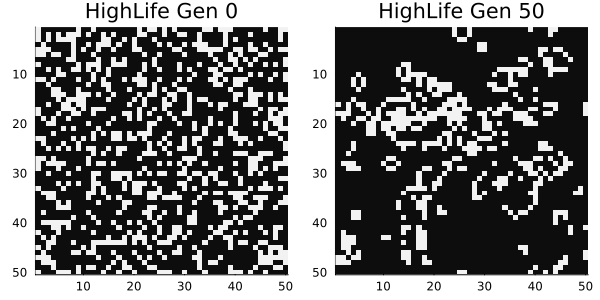

In [11]:
function ca_step_custom(grid::Matrix{Int}, birth::Vector{Int}, survival::Vector{Int})
    rows, cols = size(grid)
    nextGrid = zeros(Int, rows, cols)
    
    for i in 1:rows
        for j in 1:cols
            neighbors = count_neighbors(grid, i, j)
            state = grid[i, j]
            
            if state == 1
                # 生存条件
                if neighbors in survival
                    nextGrid[i, j] = 1
                end
            else
                # 誕生条件
                if neighbors in birth
                    nextGrid[i, j] = 1
                end
            end
        end
    end
    
    return nextGrid
end

# HighLife (B36/S23) - グライダーが自己複製する
function simulate_highlife()
    grid = rand(50, 50) .< 0.3
    grid = Int.(grid)
    
    birth = [3, 6]
    survival = [2, 3]
    
    history = [copy(grid)]
    for _ in 1:100
        grid = ca_step_custom(grid, birth, survival)
        push!(history, copy(grid))
    end
    
    p1 = heatmap(history[1], c=:grays, yflip=true, colorbar=false, title="HighLife Gen 0")
    p2 = heatmap(history[51], c=:grays, yflip=true, colorbar=false, title="HighLife Gen 50")
    
    plot(p1, p2, layout=(1,2), size=(600, 300))
end

simulate_highlife()

## 7.7 連続状態のCA

状態を0/1の二値ではなく、連続値（0.0〜1.0）にすることもできます。

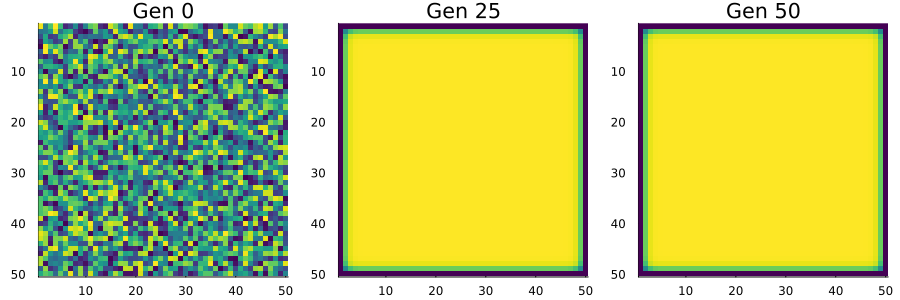

In [12]:
function continuous_ca_step(grid::Matrix{Float64})
    rows, cols = size(grid)
    nextGrid = zeros(Float64, rows, cols)
    
    for i in 2:rows-1
        for j in 2:cols-1
            # 近傍の平均
            sum = 0.0
            for di in -1:1
                for dj in -1:1
                    sum += grid[i+di, j+dj]
                end
            end
            avg = sum / 9.0
            
            # 非線形な応答関数
            nextGrid[i, j] = clamp(avg + 0.1 * sin(avg * 2π), 0.0, 1.0)
        end
    end
    
    return nextGrid
end

function simulate_continuous_ca()
    grid = rand(50, 50)
    
    history = [copy(grid)]
    for _ in 1:50
        grid = continuous_ca_step(grid)
        push!(history, copy(grid))
    end
    
    p1 = heatmap(history[1], c=:viridis, yflip=true, colorbar=false, title="Gen 0")
    p2 = heatmap(history[26], c=:viridis, yflip=true, colorbar=false, title="Gen 25")
    p3 = heatmap(history[51], c=:viridis, yflip=true, colorbar=false, title="Gen 50")
    
    plot(p1, p2, p3, layout=(1,3), size=(900, 300))
end

simulate_continuous_ca()

## 7.8 人口統計

CAの動態を可視化するために、生きているセルの数を時間軸でプロットします。

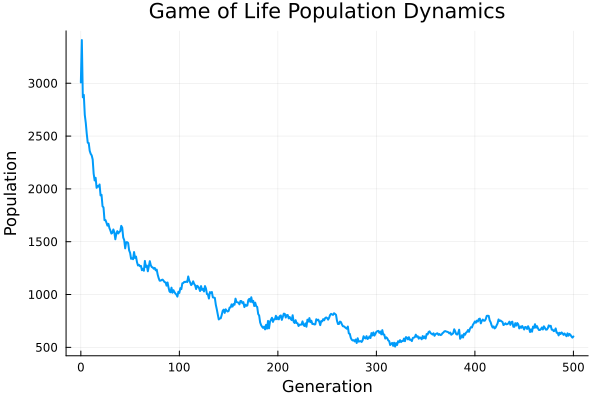

In [13]:
function analyze_population(width::Int, height::Int, generations::Int; density=0.3)
    grid = rand(height, width) .< density
    grid = Int.(grid)
    
    populations = [sum(grid)]
    
    for _ in 1:generations
        grid = game_of_life_step(grid)
        push!(populations, sum(grid))
    end
    
    plot(0:generations, populations, 
         xlabel="Generation", ylabel="Population",
         title="Game of Life Population Dynamics",
         legend=false, linewidth=2)
end

analyze_population(100, 100, 500)

## まとめ

### セル・オートマトンの特徴

1. **単純なルール、複雑な挙動**: 局所的なルールからグローバルなパターンが創発
2. **並列計算**: すべてのセルが同時に更新される
3. **決定論的**: 同じ初期条件からは常に同じ結果
4. **計算普遍性**: Rule 110やGame of Lifeはチューリング完全

### 応用分野

- 物理シミュレーション（流体、結晶成長）
- 生物学（パターン形成、生態系）
- 暗号（疑似乱数生成）
- テクスチャ生成
- 交通シミュレーション

### 重要なルール

| ルール | 分類 | 特徴 |
|--------|------|------|
| Rule 30 | Class 3 | カオス的、乱数生成に使用 |
| Rule 90 | Class 3 | シェルピンスキーの三角形 |
| Rule 110 | Class 4 | チューリング完全 |
| Game of Life | Class 4 | 最も有名な2D CA |